In [1]:
# тут всё скучное, мотайте вниз

import requests
import datetime
import dateutil

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = "retina"

plt.rcParams["figure.figsize"] = (12, 8)
sns.set(style="darkgrid", color_codes=True)
sns.set_context("notebook", font_scale=1.0)

In [3]:
def get_data(url):
    res = []
    while url is not None:
        r = requests.get(url)
        if r.status_code != 200:
            if res != []:
                raise "exploded while fetching {}".format(url)
            return []
        data = r.json()
        res.extend(data["data"])
        url = data["links"]["next"]
    return res

In [4]:
def get_campaigns():
    res = get_data("https://molamola.by/api/campaigns")
    return [r["id"] for r in res]

In [5]:
def get_payments(campaign_id):
    return get_data("https://molamola.by/api/campaigns/{}/payments".format(campaign_id))

In [6]:
def percentage(sum):
    p = sum * 0.06
    return p if p > 1.1 else 1.1

In [7]:
def collect(campaigns):
    pss = []
    for c in campaigns:
        ps = get_payments(c)
        if len(ps) != 0:
            pss.extend([{"date": dateutil.parser.parse(p["created_at"]), "сборы": p["sum"], "комиссия": percentage(p["sum"])} for p in ps])
    return pss

In [8]:
df = pd.DataFrame.from_records(collect(get_campaigns()), index="date")

In [9]:
ddf = df.groupby(by=[df.index.year, df.index.month, df.index.day]).sum()
ddf.index = ddf.index.to_flat_index().map(lambda r: datetime.date(r[0], r[1], r[2]))

mdf = df.groupby(by=[df.index.year, df.index.month]).sum()
mdf.index = mdf.index.to_flat_index().map(lambda r: datetime.date(r[0], r[1], 1))

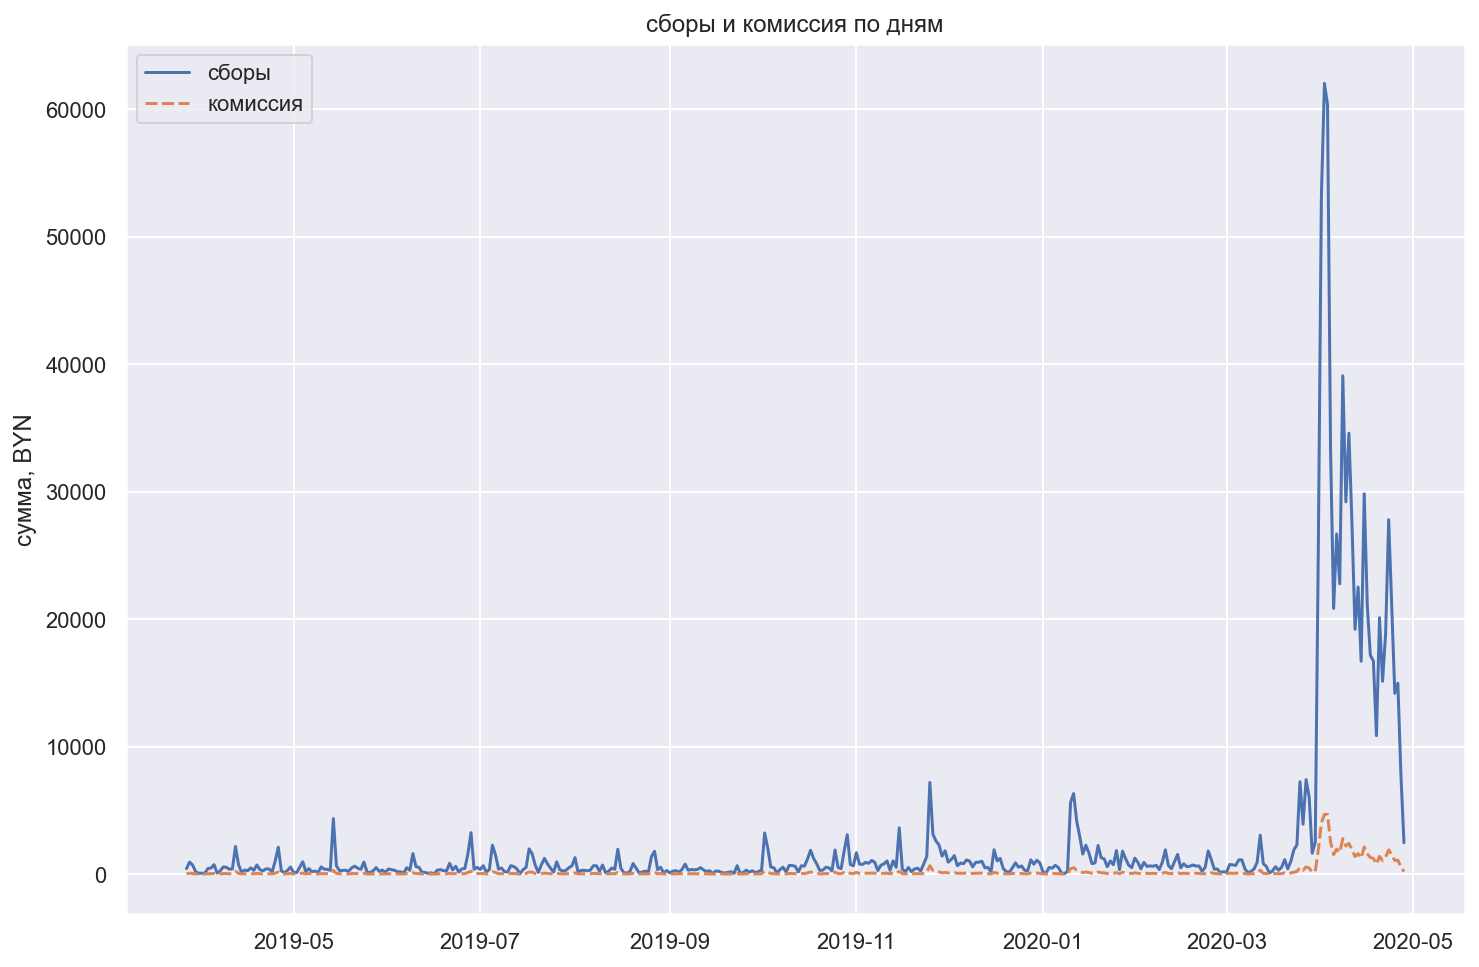

In [10]:
sns.lineplot(data=ddf)
plt.ylabel("сумма, BYN")
plt.title("сборы и комиссия по дням");

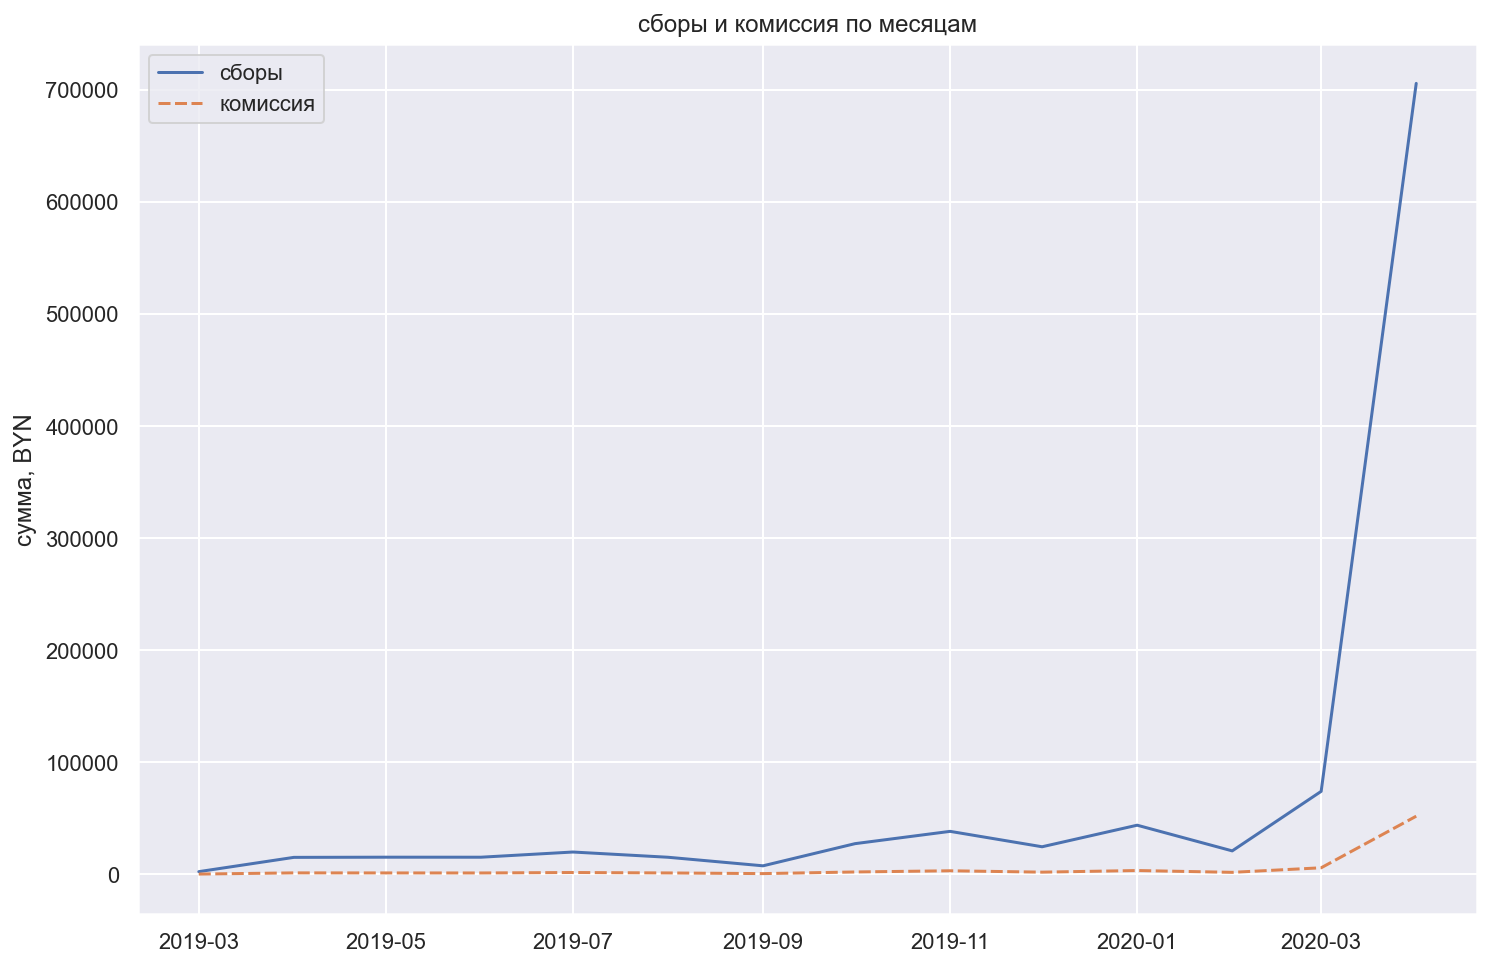

In [11]:
sns.lineplot(data=mdf)
plt.ylabel("сумма, BYN")
plt.title("сборы и комиссия по месяцам");

In [12]:
# даты как в левой колонке так и месячном графике означают начало месяца. т.е. 2020-04-01 - это то что собрано с первого апреля по сейчас.

mdf

,сборы,комиссия
2019-03-01,2330,173.80
2019-04-01,15074,1234.92
2019-05-01,15227,1187.90
2019-06-01,15207,1156.32
2019-07-01,19843,1552.00
2019-08-01,15174,1177.30
2019-09-01,7535,587.10
2019-10-01,27307,2040.40
2019-11-01,38278,3110.42
2019-12-01,24533,1879.28
